In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create project directory structure
directories = [
    'data/raw',
    'data/processed',
    'notebooks',
    'src/features',
    'src/models',
    'src/evaluation',
    'reports',
    'models'
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)
    print(f"✓ Created: {directory}")

# Create README.md
readme_content = """# Multi-Output Financial Risk Forecasting

## Project Overview
Predicting three risk dimensions for 100 companies:
- Credit Risk Score
- Liquidity Ratio
- Market Volatility Exposure

## Data
- Companies: 100
- Time Period: 2015-2024 (10 years)
- Total Records: 12,000

## Project Structure
- `data/`: Raw and processed datasets
- `notebooks/`: Jupyter notebooks for analysis
- `src/`: Source code modules
- `reports/`: Generated reports and visualizations
- `models/`: Saved model files

## Current Status
- [x] Project setup
- [ ] Data exploration
- [ ] Feature engineering
- [ ] Model training
- [ ] Evaluation
- [ ] Deployment
"""

with open('README.md', 'w') as f:
    f.write(readme_content)
print("✓ Created: README.md")

# Create requirements.txt
requirements = """pandas>=2.0.0
numpy>=1.24.0
scikit-learn>=1.3.0
xgboost>=2.0.0
matplotlib>=3.7.0
seaborn>=0.12.0
statsmodels>=0.14.0
shap>=0.42.0
jupyter>=1.0.0
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements)
print("✓ Created: requirements.txt")

print("\n" + "="*60)
print("PROJECT SETUP COMPLETE!")
print("="*60)
print("\nNext steps:")
print("1. Copy 'final_data.csv' to 'data/raw/' folder")
print("2. Install packages: pip3 install -r requirements.txt")
print("3. Ready for Step 2!")


✓ Created: data/raw
✓ Created: data/processed
✓ Created: notebooks
✓ Created: src/features
✓ Created: src/models
✓ Created: src/evaluation
✓ Created: reports
✓ Created: models
✓ Created: README.md
✓ Created: requirements.txt

PROJECT SETUP COMPLETE!

Next steps:
1. Copy 'final_data.csv' to 'data/raw/' folder
2. Install packages: pip3 install -r requirements.txt
3. Ready for Step 2!


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("="*60)
print("STEP 2: LOADING AND INSPECTING DATA")
print("="*60)

# Load data
df = pd.read_csv('data/raw/final_data.csv', parse_dates=['Date'])
print("\n✓ Data loaded successfully!")

# Basic information
print("\n" + "="*60)
print("BASIC DATA INFORMATION")
print("="*60)
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Number of companies: {df['Company_ID'].nunique()}")
print(f"Time span: {(df['Date'].max() - df['Date'].min()).days} days")

# Records per company
records_per_company = df.groupby('Company_ID').size()
print(f"\nRecords per company:")
print(f"  Min: {records_per_company.min()}")
print(f"  Max: {records_per_company.max()}")
print(f"  Mean: {records_per_company.mean():.1f}")

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Missing values
print("\n" + "="*60)
print("MISSING VALUES CHECK")
print("="*60)
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Missing_Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print(missing_df)
else:
    print("✓ No missing values found!")

# Data types
print("\n" + "="*60)
print("DATA TYPES")
print("="*60)
print(df.dtypes)

# First few rows
print("\n" + "="*60)
print("SAMPLE DATA (First 5 rows)")
print("="*60)
print(df.head())

# Target variables statistics
print("\n" + "="*60)
print("TARGET VARIABLES SUMMARY")
print("="*60)
target_cols = ['Credit_Risk_Score', 'Liquidity_Ratio', 'Market_Volatility_Exposure']
print(df[target_cols].describe())

# Save summary to file
summary_report = f"""
DATA INSPECTION REPORT
Generated: {pd.Timestamp.now()}

DATASET OVERVIEW:
- Total Records: {df.shape[0]}
- Total Features: {df.shape[1]}
- Companies: {df['Company_ID'].nunique()}
- Date Range: {df['Date'].min()} to {df['Date'].max()}
- Duplicates: {df.duplicated().sum()}

MISSING VALUES:
{missing_df.to_string() if len(missing_df) > 0 else 'None'}

TARGET VARIABLES STATISTICS:
{df[target_cols].describe().to_string()}
"""

with open('reports/data_inspection_summary.txt', 'w') as f:
    f.write(summary_report)

print("\n" + "="*60)
print("STEP 2 COMPLETE!")
print("="*60)
print("✓ Report saved to: reports/data_inspection_summary.txt")
print("\nReady for Step 3: Define Variables and Handle Missing Values")


STEP 2: LOADING AND INSPECTING DATA

✓ Data loaded successfully!

BASIC DATA INFORMATION
Shape: 12000 rows × 28 columns
Date range: 2015-01-01 00:00:00 to 2024-01-12 00:00:00
Number of companies: 100
Time span: 3298 days

Records per company:
  Min: 120
  Max: 120
  Mean: 120.0

Duplicate rows: 0

MISSING VALUES CHECK
                     Missing_Count  Missing_Percentage
VIX(Monthly_Return)            100                0.83

DATA TYPES
Date                                           datetime64[ns]
Company_ID                                             object
Company_Name                                           object
Current_Ratio                                         float64
Quick_Ratio                                           float64
Leverage_Ratio                                        float64
Profit_Margin                                         float64
Credit_Risk_Score                                     float64
Liquidity_Ratio                                       float64


In [5]:
import pandas as pd
import numpy as np

print("="*60)
print("STEP 3: DEFINE VARIABLES & HANDLE MISSING VALUES")
print("="*60)

# Load data (if not already in memory)
df = pd.read_csv('data/raw/final_data.csv', parse_dates=['Date'])

# Define target variables (what we want to predict)
TARGET_COLS = [
    'Credit_Risk_Score',
    'Liquidity_Ratio',
    'Market_Volatility_Exposure'
]

# Define firm-level features
FIRM_FEATURES = [
    'Current_Ratio',
    'Quick_Ratio',
    'Leverage_Ratio',
    'Profit_Margin'
]

# Define macro-economic features
MACRO_FEATURES = [
    'GDP Growth rate',
    'CPI Inflation index',
    'Policy Repo rate',
    'Unemployment Rate(%)',
    'Money Supply (M2)(000\'Billion)'
]

# Define market features
MARKET_FEATURES = [
    'Stock Market Index(Monthly_Close)',
    'Stock Market Index(Monthly_Return)',
    'Stock Market Index(Monthly_Volatility)',
    'VIX(Monthly_Close)',
    'VIX(Monthly_Return)',
    'VIX(Monthly_Volatility)',
    '10-Year Government Bond Yield',
    'AAA Corporate Bond Yield',
    'Government Bond Yield (%) (10Y benchmark)',
    'Corporate Bond Spread',
    'Exchange Rate (USD/INR)(Monthly_Close)',
    'Exchange Rate (USD/INR)(Monthly_Return)',
    'Exchange Rate (USD/INR)(Monthly_Volatility)'
]

print("\n✓ Variable groups defined:")
print(f"  - Target variables: {len(TARGET_COLS)}")
print(f"  - Firm features: {len(FIRM_FEATURES)}")
print(f"  - Macro features: {len(MACRO_FEATURES)}")
print(f"  - Market features: {len(MARKET_FEATURES)}")

# Handle missing values in VIX(Monthly_Return)
print("\n" + "="*60)
print("HANDLING MISSING VALUES")
print("="*60)

print(f"\nBefore: VIX(Monthly_Return) missing = {df['VIX(Monthly_Return)'].isnull().sum()}")

# Sort by company and date for proper forward fill
df = df.sort_values(['Company_ID', 'Date']).reset_index(drop=True)

# Forward fill within each company, then backward fill if needed
df['VIX(Monthly_Return)'] = df.groupby('Company_ID')['VIX(Monthly_Return)'].fillna(method='ffill')
df['VIX(Monthly_Return)'] = df.groupby('Company_ID')['VIX(Monthly_Return)'].fillna(method='bfill')

print(f"After:  VIX(Monthly_Return) missing = {df['VIX(Monthly_Return)'].isnull().sum()}")

# Final check for any remaining missing values
total_missing = df.isnull().sum().sum()
if total_missing == 0:
    print("\n✓ All missing values handled successfully!")
else:
    print(f"\n⚠ Warning: {total_missing} missing values remain")
    print(df.isnull().sum()[df.isnull().sum() > 0])

# Save cleaned data
df.to_csv('data/processed/data_cleaned.csv', index=False)
print("\n✓ Cleaned data saved to: data/processed/data_cleaned.csv")

# Summary of all feature groups
print("\n" + "="*60)
print("FEATURE GROUPS SUMMARY")
print("="*60)

all_features = {
    'Target Variables': TARGET_COLS,
    'Firm-Level Features': FIRM_FEATURES,
    'Macro-Economic Features': MACRO_FEATURES,
    'Market Features': MARKET_FEATURES
}

for group_name, features in all_features.items():
    print(f"\n{group_name} ({len(features)}):")
    for i, feat in enumerate(features, 1):
        print(f"  {i}. {feat}")

# Save feature definitions to a file for reference
feature_doc = """
FEATURE DEFINITIONS FOR MULTI-OUTPUT RISK FORECASTING
======================================================

TARGET VARIABLES (What we predict):
"""
for i, col in enumerate(TARGET_COLS, 1):
    feature_doc += f"{i}. {col}\n"

feature_doc += "\nFIRM-LEVEL FEATURES (Company financial ratios):\n"
for i, col in enumerate(FIRM_FEATURES, 1):
    feature_doc += f"{i}. {col}\n"

feature_doc += "\nMACRO-ECONOMIC FEATURES (Economic indicators):\n"
for i, col in enumerate(MACRO_FEATURES, 1):
    feature_doc += f"{i}. {col}\n"

feature_doc += "\nMARKET FEATURES (Market & volatility indicators):\n"
for i, col in enumerate(MARKET_FEATURES, 1):
    feature_doc += f"{i}. {col}\n"

with open('reports/feature_definitions.txt', 'w') as f:
    f.write(feature_doc)

print("\n" + "="*60)
print("STEP 3 COMPLETE!")
print("="*60)
print("✓ Feature definitions saved to: reports/feature_definitions.txt")
print("\nDataset ready for feature engineering!")
print(f"Total features to use: {len(FIRM_FEATURES) + len(MACRO_FEATURES) + len(MARKET_FEATURES)}")
print(f"\nReady for Step 4: Feature Engineering (Create Lag & Rolling Features)")


STEP 3: DEFINE VARIABLES & HANDLE MISSING VALUES

✓ Variable groups defined:
  - Target variables: 3
  - Firm features: 4
  - Macro features: 5
  - Market features: 13

HANDLING MISSING VALUES

Before: VIX(Monthly_Return) missing = 100
After:  VIX(Monthly_Return) missing = 0

✓ All missing values handled successfully!

✓ Cleaned data saved to: data/processed/data_cleaned.csv

FEATURE GROUPS SUMMARY

Target Variables (3):
  1. Credit_Risk_Score
  2. Liquidity_Ratio
  3. Market_Volatility_Exposure

Firm-Level Features (4):
  1. Current_Ratio
  2. Quick_Ratio
  3. Leverage_Ratio
  4. Profit_Margin

Macro-Economic Features (5):
  1. GDP Growth rate
  2. CPI Inflation index
  3. Policy Repo rate
  4. Unemployment Rate(%)
  5. Money Supply (M2)(000'Billion)

Market Features (13):
  1. Stock Market Index(Monthly_Close)
  2. Stock Market Index(Monthly_Return)
  3. Stock Market Index(Monthly_Volatility)
  4. VIX(Monthly_Close)
  5. VIX(Monthly_Return)
  6. VIX(Monthly_Volatility)
  7. 10-Year G

In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm

print("="*60)
print("STEP 4: FEATURE ENGINEERING")
print("="*60)

# Load cleaned data
df = pd.read_csv('data/processed/data_cleaned.csv', parse_dates=['Date'])
print(f"\n✓ Loaded cleaned data: {df.shape}")

# Ensure sorted by Company and Date
df = df.sort_values(['Company_ID', 'Date']).reset_index(drop=True)

# Define features to engineer
FEATURES_TO_ENGINEER = [
    # Firm-level features
    'Current_Ratio',
    'Quick_Ratio',
    'Leverage_Ratio',
    'Profit_Margin',
    # Key macro features
    'GDP Growth rate',
    'CPI Inflation index',
    'Policy Repo rate',
    # Key market features
    'Stock Market Index(Monthly_Return)',
    'Stock Market Index(Monthly_Volatility)',
    'VIX(Monthly_Close)',
    'VIX(Monthly_Return)',
    '10-Year Government Bond Yield',
    'Exchange Rate (USD/INR)(Monthly_Return)'
]

print(f"\n✓ Features to engineer: {len(FEATURES_TO_ENGINEER)}")
print("\nCreating time series features...")

# Track new features created
new_features = []
initial_cols = df.shape[1]

print("\n" + "="*60)
print("CREATING LAG FEATURES")
print("="*60)

# Create lag features (1, 3, 6 months)
lag_periods = [1, 3, 6]
for col in FEATURES_TO_ENGINEER:
    for lag in lag_periods:
        new_col = f'{col}_lag{lag}'
        df[new_col] = df.groupby('Company_ID')[col].shift(lag)
        new_features.append(new_col)
    print(f"✓ {col}: Created lags 1, 3, 6")

print(f"\nTotal lag features created: {len(lag_periods) * len(FEATURES_TO_ENGINEER)}")

print("\n" + "="*60)
print("CREATING ROLLING MEAN FEATURES")
print("="*60)

# Create rolling mean features (3, 6, 12 months)
rolling_windows = [3, 6, 12]
for col in FEATURES_TO_ENGINEER:
    for window in rolling_windows:
        new_col = f'{col}_rolling{window}_mean'
        df[new_col] = df.groupby('Company_ID')[col].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        new_features.append(new_col)
    print(f"✓ {col}: Created rolling means (3, 6, 12)")

print(f"\nTotal rolling mean features created: {len(rolling_windows) * len(FEATURES_TO_ENGINEER)}")

print("\n" + "="*60)
print("CREATING ROLLING STD FEATURES")
print("="*60)

# Create rolling std features (3, 6 months) - measure of volatility
rolling_std_windows = [3, 6]
for col in FEATURES_TO_ENGINEER:
    for window in rolling_std_windows:
        new_col = f'{col}_rolling{window}_std'
        df[new_col] = df.groupby('Company_ID')[col].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )
        new_features.append(new_col)
    print(f"✓ {col}: Created rolling std (3, 6)")

print(f"\nTotal rolling std features created: {len(rolling_std_windows) * len(FEATURES_TO_ENGINEER)}")

# Summary
print("\n" + "="*60)
print("FEATURE ENGINEERING SUMMARY")
print("="*60)
print(f"Original features: {initial_cols}")
print(f"New features created: {len(new_features)}")
print(f"Total features now: {df.shape[1]}")
print(f"\nFeature breakdown:")
print(f"  - Lag features (1,3,6 months): {len(lag_periods) * len(FEATURES_TO_ENGINEER)}")
print(f"  - Rolling mean (3,6,12 months): {len(rolling_windows) * len(FEATURES_TO_ENGINEER)}")
print(f"  - Rolling std (3,6 months): {len(rolling_std_windows) * len(FEATURES_TO_ENGINEER)}")

# Check for any inf or extreme values
print("\n" + "="*60)
print("DATA QUALITY CHECK")
print("="*60)
inf_count = np.isinf(df.select_dtypes(include=[np.number])).sum().sum()
print(f"Infinite values: {inf_count}")

if inf_count > 0:
    # Replace inf with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    print("✓ Infinite values replaced with NaN")

# Check missing values from lag/rolling features
missing_after = df.isnull().sum().sum()
print(f"Missing values (from lag/rolling): {missing_after}")
print(f"Missing percentage: {(missing_after / (df.shape[0] * df.shape[1]) * 100):.2f}%")

# Save engineered data
df.to_csv('data/processed/data_with_features.csv', index=False)
print("\n✓ Data with engineered features saved to: data/processed/data_with_features.csv")

# Show sample of new features
print("\n" + "="*60)
print("SAMPLE OF ENGINEERED FEATURES")
print("="*60)
sample_cols = ['Date', 'Company_ID', 'Current_Ratio', 
               'Current_Ratio_lag1', 'Current_Ratio_rolling3_mean', 
               'Current_Ratio_rolling3_std']
print(df[sample_cols].head(10))

# Save feature list for reference
feature_list = {
    'original_features': initial_cols,
    'engineered_features': new_features,
    'total_features': df.shape[1]
}

with open('reports/engineered_features_list.txt', 'w') as f:
    f.write("ENGINEERED FEATURES LIST\n")
    f.write("="*60 + "\n\n")
    f.write(f"Total engineered features: {len(new_features)}\n\n")
    for i, feat in enumerate(new_features, 1):
        f.write(f"{i}. {feat}\n")

print("\n✓ Feature list saved to: reports/engineered_features_list.txt")

print("\n" + "="*60)
print("STEP 4 COMPLETE!")
print("="*60)
print("\nReady for Step 5: Train/Test Split")


STEP 4: FEATURE ENGINEERING

✓ Loaded cleaned data: (12000, 28)

✓ Features to engineer: 13

Creating time series features...

CREATING LAG FEATURES
✓ Current_Ratio: Created lags 1, 3, 6
✓ Quick_Ratio: Created lags 1, 3, 6
✓ Leverage_Ratio: Created lags 1, 3, 6
✓ Profit_Margin: Created lags 1, 3, 6
✓ GDP Growth rate: Created lags 1, 3, 6
✓ CPI Inflation index: Created lags 1, 3, 6
✓ Policy Repo rate: Created lags 1, 3, 6
✓ Stock Market Index(Monthly_Return): Created lags 1, 3, 6
✓ Stock Market Index(Monthly_Volatility): Created lags 1, 3, 6
✓ VIX(Monthly_Close): Created lags 1, 3, 6
✓ VIX(Monthly_Return): Created lags 1, 3, 6
✓ 10-Year Government Bond Yield: Created lags 1, 3, 6
✓ Exchange Rate (USD/INR)(Monthly_Return): Created lags 1, 3, 6

Total lag features created: 39

CREATING ROLLING MEAN FEATURES
✓ Current_Ratio: Created rolling means (3, 6, 12)
✓ Quick_Ratio: Created rolling means (3, 6, 12)
✓ Leverage_Ratio: Created rolling means (3, 6, 12)
✓ Profit_Margin: Created rolling me

In [7]:
import pandas as pd
import numpy as np

print("="*60)
print("STEP 5: TRAIN/TEST SPLIT")
print("="*60)

# Load data with engineered features
df = pd.read_csv('data/processed/data_with_features.csv', parse_dates=['Date'])
print(f"\n✓ Loaded data: {df.shape}")

# Remove rows with NaN values (from lag features)
print("\n" + "="*60)
print("HANDLING MISSING VALUES FROM LAG FEATURES")
print("="*60)
print(f"Rows before cleaning: {len(df)}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Drop rows with any NaN (these are from initial lag periods)
df_clean = df.dropna().reset_index(drop=True)
print(f"Rows after cleaning: {len(df_clean)}")
print(f"Rows removed: {len(df) - len(df_clean)}")

# Check distribution across companies
print(f"\nCompanies remaining: {df_clean['Company_ID'].nunique()}")
records_per_company = df_clean.groupby('Company_ID').size()
print(f"Records per company after cleaning:")
print(f"  Min: {records_per_company.min()}")
print(f"  Max: {records_per_company.max()}")
print(f"  Mean: {records_per_company.mean():.1f}")

# Time-based split
print("\n" + "="*60)
print("TIME-BASED TRAIN/TEST SPLIT")
print("="*60)

# Use last 12 months as test set
split_date = df_clean['Date'].max() - pd.DateOffset(months=12)
print(f"Split date: {split_date}")

train_df = df_clean[df_clean['Date'] < split_date].copy()
test_df = df_clean[df_clean['Date'] >= split_date].copy()

print(f"\nTrain set:")
print(f"  Date range: {train_df['Date'].min()} to {train_df['Date'].max()}")
print(f"  Records: {len(train_df)}")
print(f"  Companies: {train_df['Company_ID'].nunique()}")

print(f"\nTest set:")
print(f"  Date range: {test_df['Date'].min()} to {test_df['Date'].max()}")
print(f"  Records: {len(test_df)}")
print(f"  Companies: {test_df['Company_ID'].nunique()}")

# Calculate split ratio
train_ratio = len(train_df) / len(df_clean) * 100
test_ratio = len(test_df) / len(df_clean) * 100
print(f"\nSplit ratio: {train_ratio:.1f}% train / {test_ratio:.1f}% test")

# Define target and feature columns
print("\n" + "="*60)
print("PREPARING FEATURES AND TARGETS")
print("="*60)

TARGET_COLS = [
    'Credit_Risk_Score',
    'Liquidity_Ratio',
    'Market_Volatility_Exposure'
]

# Select all features (exclude metadata and targets)
exclude_cols = ['Date', 'Company_ID', 'Company_Name'] + TARGET_COLS
feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

print(f"Total features for modeling: {len(feature_cols)}")
print(f"Target variables: {len(TARGET_COLS)}")

# Create feature and target arrays
X_train = train_df[feature_cols]
y_train = train_df[TARGET_COLS]
X_test = test_df[feature_cols]
y_test = test_df[TARGET_COLS]

print(f"\nTraining data shape:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")

print(f"\nTest data shape:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")

# Check for any remaining issues
print("\n" + "="*60)
print("DATA QUALITY FINAL CHECK")
print("="*60)
print(f"X_train - Missing: {X_train.isnull().sum().sum()}, Inf: {np.isinf(X_train).sum().sum()}")
print(f"X_test - Missing: {X_test.isnull().sum().sum()}, Inf: {np.isinf(X_test).sum().sum()}")
print(f"y_train - Missing: {y_train.isnull().sum().sum()}, Inf: {np.isinf(y_train).sum().sum()}")
print(f"y_test - Missing: {y_test.isnull().sum().sum()}, Inf: {np.isinf(y_test).sum().sum()}")

# Save split datasets
train_df.to_csv('data/processed/train_data.csv', index=False)
test_df.to_csv('data/processed/test_data.csv', index=False)
print("\n✓ Train data saved to: data/processed/train_data.csv")
print("✓ Test data saved to: data/processed/test_data.csv")

# Save feature columns list for reference
with open('reports/model_features.txt', 'w') as f:
    f.write("FEATURES FOR MODELING\n")
    f.write("="*60 + "\n\n")
    f.write(f"Total features: {len(feature_cols)}\n\n")
    for i, feat in enumerate(feature_cols, 1):
        f.write(f"{i}. {feat}\n")
    f.write(f"\n\nTARGET VARIABLES:\n")
    for i, target in enumerate(TARGET_COLS, 1):
        f.write(f"{i}. {target}\n")

print("✓ Feature list saved to: reports/model_features.txt")

# Summary statistics
print("\n" + "="*60)
print("TRAIN/TEST SPLIT SUMMARY")
print("="*60)
summary = f"""
Dataset Split Complete!

TRAINING SET:
  - Records: {len(train_df):,}
  - Date Range: {train_df['Date'].min()} to {train_df['Date'].max()}
  - Features: {len(feature_cols)}
  - Targets: {len(TARGET_COLS)}

TEST SET:
  - Records: {len(test_df):,}
  - Date Range: {test_df['Date'].min()} to {test_df['Date'].max()}
  - Features: {len(feature_cols)}
  - Targets: {len(TARGET_COLS)}

SPLIT RATIO: {train_ratio:.1f}% / {test_ratio:.1f}%
"""
print(summary)

print("="*60)
print("STEP 5 COMPLETE!")
print("="*60)
print("\nReady for Step 6: Build Baseline Multi-Output Model")


STEP 5: TRAIN/TEST SPLIT

✓ Loaded data: (12000, 132)

HANDLING MISSING VALUES FROM LAG FEATURES
Rows before cleaning: 12000
Missing values: 15600
Rows after cleaning: 11400
Rows removed: 600

Companies remaining: 100
Records per company after cleaning:
  Min: 114
  Max: 114
  Mean: 114.0

TIME-BASED TRAIN/TEST SPLIT
Split date: 2023-01-12 00:00:00

Train set:
  Date range: 2015-01-07 00:00:00 to 2023-01-11 00:00:00
  Records: 10100
  Companies: 100

Test set:
  Date range: 2023-01-12 00:00:00 to 2024-01-12 00:00:00
  Records: 1300
  Companies: 100

Split ratio: 88.6% train / 11.4% test

PREPARING FEATURES AND TARGETS
Total features for modeling: 126
Target variables: 3

Training data shape:
  X_train: (10100, 126)
  y_train: (10100, 3)

Test data shape:
  X_test: (1300, 126)
  y_test: (1300, 3)

DATA QUALITY FINAL CHECK
X_train - Missing: 0, Inf: 0
X_test - Missing: 0, Inf: 0
y_train - Missing: 0, Inf: 0
y_test - Missing: 0, Inf: 0

✓ Train data saved to: data/processed/train_data.csv

In [9]:
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("STEP 6: BUILD BASELINE MULTI-OUTPUT MODEL")
print("="*60)

# Load prepared data
train_df = pd.read_csv('data/processed/train_data.csv', parse_dates=['Date'])
test_df = pd.read_csv('data/processed/test_data.csv', parse_dates=['Date'])

TARGET_COLS = [
    'Credit_Risk_Score',
    'Liquidity_Ratio',
    'Market_Volatility_Exposure'
]

exclude_cols = ['Date', 'Company_ID', 'Company_Name'] + TARGET_COLS
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

X_train = train_df[feature_cols]
y_train = train_df[TARGET_COLS]
X_test = test_df[feature_cols]
y_test = test_df[TARGET_COLS]

print(f"\n✓ Data loaded:")
print(f"  Train: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"  Test: {X_test.shape[0]} samples")
print(f"  Targets: {len(TARGET_COLS)}")

# Initialize model
print("\n" + "="*60)
print("INITIALIZING RANDOM FOREST MODEL")
print("="*60)

base_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

model = MultiOutputRegressor(base_model)

print("✓ Model initialized:")
print(f"  Algorithm: Random Forest")
print(f"  Trees: 100")
print(f"  Max Depth: 15")
print(f"  Multi-output: Yes")

# Train model
print("\n" + "="*60)
print("TRAINING MODEL")
print("="*60)
print("Training in progress...")

start_time = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"✓ Training complete!")
print(f"  Training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

# Make predictions
print("\n" + "="*60)
print("MAKING PREDICTIONS")
print("="*60)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("✓ Predictions generated for train and test sets")

# Evaluation function (FIXED)
def evaluate_predictions(y_true, y_pred, target_names, dataset_name=''):
    results = {}
    print(f"\n{'='*60}")
    print(f"{dataset_name.upper()} PERFORMANCE")
    print(f"{'='*60}")
    
    for i, target in enumerate(target_names):
        # Calculate MSE first, then take square root for RMSE
        mse = mean_squared_error(y_true.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true.iloc[:, i], y_pred[:, i])
        r2 = r2_score(y_true.iloc[:, i], y_pred[:, i])
        
        # Calculate MAPE (Mean Absolute Percentage Error)
        mape = np.mean(np.abs((y_true.iloc[:, i] - y_pred[:, i]) / y_true.iloc[:, i])) * 100
        
        results[target] = {
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'MAPE': mape
        }
        
        print(f"\n{target}:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE:  {mae:.4f}")
        print(f"  R²:   {r2:.4f}")
        print(f"  MAPE: {mape:.2f}%")
    
    return results

# Evaluate on both sets
train_results = evaluate_predictions(y_train, y_pred_train, TARGET_COLS, 'Train Set')
test_results = evaluate_predictions(y_test, y_pred_test, TARGET_COLS, 'Test Set')

# Compare train vs test (check for overfitting)
print("\n" + "="*60)
print("OVERFITTING CHECK (Train vs Test R²)")
print("="*60)
for target in TARGET_COLS:
    train_r2 = train_results[target]['R2']
    test_r2 = test_results[target]['R2']
    diff = train_r2 - test_r2
    status = "✓ Good" if diff < 0.1 else "⚠ Possible overfitting"
    print(f"\n{target}:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  Difference: {diff:.4f} {status}")

# Save predictions
print("\n" + "="*60)
print("SAVING RESULTS")
print("="*60)

# Save test predictions with metadata
test_predictions = test_df[['Date', 'Company_ID', 'Company_Name']].copy()
for i, target in enumerate(TARGET_COLS):
    test_predictions[f'{target}_Actual'] = y_test.iloc[:, i].values
    test_predictions[f'{target}_Predicted'] = y_pred_test[:, i]
    test_predictions[f'{target}_Error'] = test_predictions[f'{target}_Actual'] - test_predictions[f'{target}_Predicted']

test_predictions.to_csv('data/processed/test_predictions.csv', index=False)
print("✓ Predictions saved to: data/processed/test_predictions.csv")

# Save evaluation metrics
metrics_df = pd.DataFrame({
    'Target': TARGET_COLS,
    'Train_RMSE': [train_results[t]['RMSE'] for t in TARGET_COLS],
    'Test_RMSE': [test_results[t]['RMSE'] for t in TARGET_COLS],
    'Train_MAE': [train_results[t]['MAE'] for t in TARGET_COLS],
    'Test_MAE': [test_results[t]['MAE'] for t in TARGET_COLS],
    'Train_R2': [train_results[t]['R2'] for t in TARGET_COLS],
    'Test_R2': [test_results[t]['R2'] for t in TARGET_COLS],
    'Test_MAPE': [test_results[t]['MAPE'] for t in TARGET_COLS]
})

metrics_df.to_csv('reports/model_evaluation_metrics.csv', index=False)
print("✓ Metrics saved to: reports/model_evaluation_metrics.csv")

# Save model
import pickle
with open('models/baseline_random_forest.pkl', 'wb') as f:
    pickle.dump(model, f)
print("✓ Model saved to: models/baseline_random_forest.pkl")

# Create summary report
summary_report = f"""
BASELINE MODEL EVALUATION REPORT
{'='*60}

MODEL CONFIGURATION:
  Algorithm: Random Forest Multi-Output Regressor
  Training Samples: {X_train.shape[0]:,}
  Test Samples: {X_test.shape[0]:,}
  Features: {X_train.shape[1]}
  Targets: {len(TARGET_COLS)}
  Training Time: {training_time:.2f} seconds

TEST SET PERFORMANCE:
"""

for target in TARGET_COLS:
    summary_report += f"""
  {target}:
    RMSE: {test_results[target]['RMSE']:.4f}
    MAE:  {test_results[target]['MAE']:.4f}
    R²:   {test_results[target]['R2']:.4f}
    MAPE: {test_results[target]['MAPE']:.2f}%
"""

summary_report += f"""
OVERALL PERFORMANCE:
  Average R² Score: {np.mean([test_results[t]['R2'] for t in TARGET_COLS]):.4f}
  Average MAPE: {np.mean([test_results[t]['MAPE'] for t in TARGET_COLS]):.2f}%
"""

with open('reports/baseline_model_summary.txt', 'w') as f:
    f.write(summary_report)

print("✓ Summary report saved to: reports/baseline_model_summary.txt")

print("\n" + "="*60)
print("STEP 6 COMPLETE!")
print("="*60)
print(f"\nBaseline Model Summary:")
print(f"  Average Test R²: {np.mean([test_results[t]['R2'] for t in TARGET_COLS]):.4f}")
print(f"  Average Test MAPE: {np.mean([test_results[t]['MAPE'] for t in TARGET_COLS]):.2f}%")
print("\nReady for Step 7: Feature Importance Analysis")


STEP 6: BUILD BASELINE MULTI-OUTPUT MODEL

✓ Data loaded:
  Train: 10100 samples, 126 features
  Test: 1300 samples
  Targets: 3

INITIALIZING RANDOM FOREST MODEL
✓ Model initialized:
  Algorithm: Random Forest
  Trees: 100
  Max Depth: 15
  Multi-output: Yes

TRAINING MODEL
Training in progress...
✓ Training complete!
  Training time: 26.48 seconds (0.44 minutes)

MAKING PREDICTIONS
✓ Predictions generated for train and test sets

TRAIN SET PERFORMANCE

Credit_Risk_Score:
  RMSE: 2.6091
  MAE:  2.0682
  R²:   0.8800
  MAPE: 3.53%

Liquidity_Ratio:
  RMSE: 0.1325
  MAE:  0.0900
  R²:   0.9201
  MAPE: 7.51%

Market_Volatility_Exposure:
  RMSE: 0.1175
  MAE:  0.0935
  R²:   0.7525
  MAPE: 7.63%

TEST SET PERFORMANCE

Credit_Risk_Score:
  RMSE: 5.0616
  MAE:  4.0364
  R²:   0.5338
  MAPE: 6.85%

Liquidity_Ratio:
  RMSE: 0.2175
  MAE:  0.1525
  R²:   0.7874
  MAPE: 12.19%

Market_Volatility_Exposure:
  RMSE: 0.2009
  MAE:  0.1609
  R²:   0.2981
  MAPE: 13.05%

OVERFITTING CHECK (Train vs T

STEP 7: FEATURE IMPORTANCE ANALYSIS

✓ Model and features loaded
  Total features: 126
  Total targets: 3

EXTRACTING FEATURE IMPORTANCES
✓ Extracted importances for Credit_Risk_Score
✓ Extracted importances for Liquidity_Ratio
✓ Extracted importances for Market_Volatility_Exposure

✓ Full feature importance saved to: reports/feature_importance_full.csv

TOP 20 MOST IMPORTANT FEATURES (By Average)
                     Feature  Average_Importance
              Leverage_Ratio            0.303032
               Current_Ratio            0.278926
               Profit_Margin            0.011567
         Leverage_Ratio_lag6            0.011313
    Quick_Ratio_rolling6_std            0.011170
  Current_Ratio_rolling6_std            0.010391
  Current_Ratio_rolling3_std            0.010301
 Leverage_Ratio_rolling6_std            0.010266
    Quick_Ratio_rolling3_std            0.010256
  Profit_Margin_rolling6_std            0.010179
  Profit_Margin_rolling3_std            0.010023
 Leverage_R

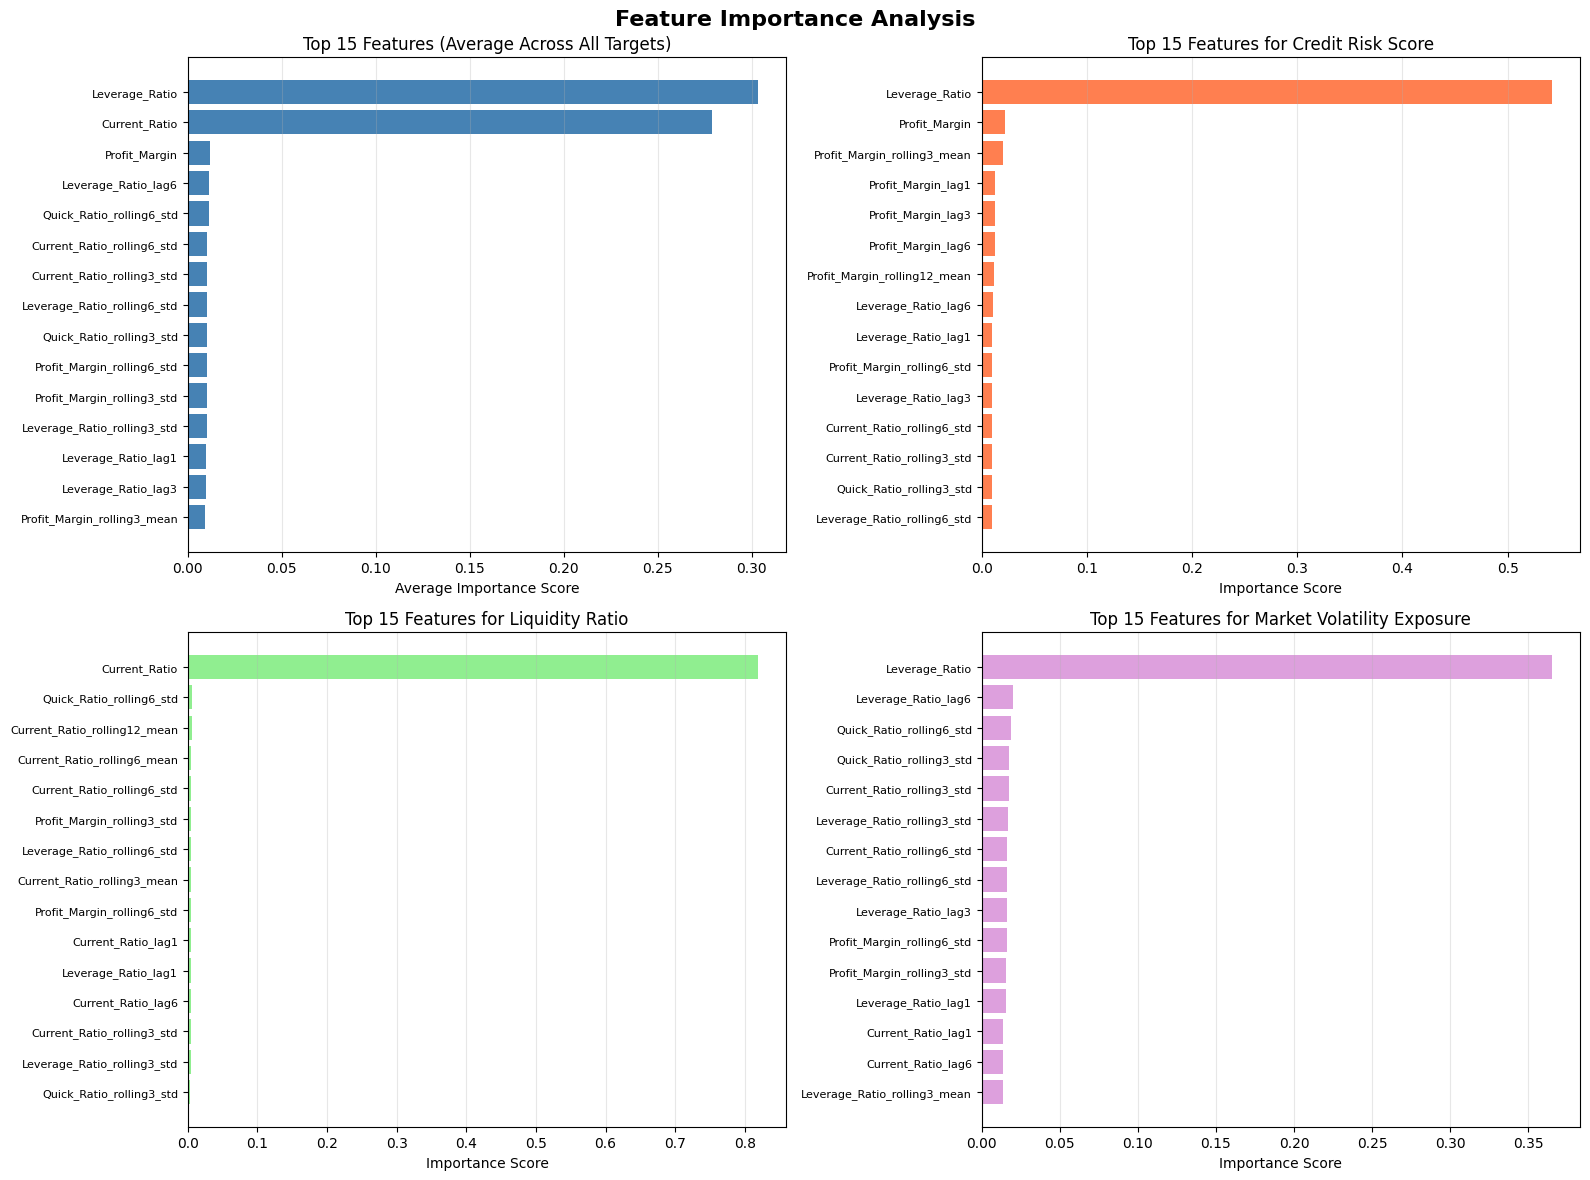


FEATURE CATEGORY ANALYSIS

Importance by Feature Category:
                            sum      mean  count
Category                                        
Original Features      0.625770  0.028444     22
Lag Features           0.148645  0.003811     39
Rolling Std Features   0.119971  0.004614     26
Rolling Mean Features  0.105614  0.002708     39

✓ Summary saved to: reports/feature_importance_summary.txt

STEP 7 COMPLETE!

Key Findings:
  Most important feature: Leverage_Ratio
  Importance score: 0.3030

  Category with highest total importance:
    Original Features: 0.6258

Next Steps:
  1. Review feature_importance_plots.png
  2. Consider feature selection based on importance
  3. Move to Step 8: Model Improvement Strategies


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

print("="*60)
print("STEP 7: FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Load the trained model
with open('models/baseline_random_forest.pkl', 'rb') as f:
    model = pickle.load(f)

# Load data to get feature names
train_df = pd.read_csv('data/processed/train_data.csv')

TARGET_COLS = [
    'Credit_Risk_Score',
    'Liquidity_Ratio',
    'Market_Volatility_Exposure'
]

exclude_cols = ['Date', 'Company_ID', 'Company_Name'] + TARGET_COLS
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

print(f"\n✓ Model and features loaded")
print(f"  Total features: {len(feature_cols)}")
print(f"  Total targets: {len(TARGET_COLS)}")

# Extract feature importances for each target
print("\n" + "="*60)
print("EXTRACTING FEATURE IMPORTANCES")
print("="*60)

feature_importance_dict = {}

for i, target in enumerate(TARGET_COLS):
    # Get feature importances from individual model
    importances = model.estimators_[i].feature_importances_
    feature_importance_dict[target] = importances
    print(f"✓ Extracted importances for {target}")

# Create dataframe with all importances
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Credit_Risk_Score': feature_importance_dict['Credit_Risk_Score'],
    'Liquidity_Ratio': feature_importance_dict['Liquidity_Ratio'],
    'Market_Volatility_Exposure': feature_importance_dict['Market_Volatility_Exposure']
})

# Calculate average importance across all targets
importance_df['Average_Importance'] = importance_df[TARGET_COLS].mean(axis=1)

# Sort by average importance
importance_df = importance_df.sort_values('Average_Importance', ascending=False)

# Save full feature importance table
importance_df.to_csv('reports/feature_importance_full.csv', index=False)
print("\n✓ Full feature importance saved to: reports/feature_importance_full.csv")

# Display top 20 features
print("\n" + "="*60)
print("TOP 20 MOST IMPORTANT FEATURES (By Average)")
print("="*60)
print(importance_df.head(20)[['Feature', 'Average_Importance']].to_string(index=False))

# Top features for each target
print("\n" + "="*60)
print("TOP 10 FEATURES FOR EACH TARGET")
print("="*60)

for target in TARGET_COLS:
    print(f"\n{target}:")
    top_features = importance_df.nlargest(10, target)[['Feature', target]]
    for idx, row in top_features.iterrows():
        print(f"  {row['Feature']}: {row[target]:.4f}")

# Create visualization data
top_n = 15
top_features_df = importance_df.head(top_n).copy()

# Create visualization
print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Feature Importance Analysis', fontsize=16, fontweight='bold')

# Plot 1: Overall top features (average)
ax1 = axes[0, 0]
y_pos = np.arange(len(top_features_df))
ax1.barh(y_pos, top_features_df['Average_Importance'], color='steelblue')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(top_features_df['Feature'], fontsize=8)
ax1.invert_yaxis()
ax1.set_xlabel('Average Importance Score')
ax1.set_title(f'Top {top_n} Features (Average Across All Targets)')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Credit Risk Score
ax2 = axes[0, 1]
top_credit = importance_df.nlargest(top_n, 'Credit_Risk_Score')
y_pos = np.arange(len(top_credit))
ax2.barh(y_pos, top_credit['Credit_Risk_Score'], color='coral')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(top_credit['Feature'], fontsize=8)
ax2.invert_yaxis()
ax2.set_xlabel('Importance Score')
ax2.set_title(f'Top {top_n} Features for Credit Risk Score')
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Liquidity Ratio
ax3 = axes[1, 0]
top_liquidity = importance_df.nlargest(top_n, 'Liquidity_Ratio')
y_pos = np.arange(len(top_liquidity))
ax3.barh(y_pos, top_liquidity['Liquidity_Ratio'], color='lightgreen')
ax3.set_yticks(y_pos)
ax3.set_yticklabels(top_liquidity['Feature'], fontsize=8)
ax3.invert_yaxis()
ax3.set_xlabel('Importance Score')
ax3.set_title(f'Top {top_n} Features for Liquidity Ratio')
ax3.grid(axis='x', alpha=0.3)

# Plot 4: Market Volatility Exposure
ax4 = axes[1, 1]
top_volatility = importance_df.nlargest(top_n, 'Market_Volatility_Exposure')
y_pos = np.arange(len(top_volatility))
ax4.barh(y_pos, top_volatility['Market_Volatility_Exposure'], color='plum')
ax4.set_yticks(y_pos)
ax4.set_yticklabels(top_volatility['Feature'], fontsize=8)
ax4.invert_yaxis()
ax4.set_xlabel('Importance Score')
ax4.set_title(f'Top {top_n} Features for Market Volatility Exposure')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('reports/feature_importance_plots.png', dpi=300, bbox_inches='tight')
print("✓ Feature importance plots saved to: reports/feature_importance_plots.png")
plt.show()

# Feature category analysis
print("\n" + "="*60)
print("FEATURE CATEGORY ANALYSIS")
print("="*60)

def categorize_feature(feat_name):
    if 'lag' in feat_name.lower():
        return 'Lag Features'
    elif 'rolling' in feat_name.lower() and 'mean' in feat_name.lower():
        return 'Rolling Mean Features'
    elif 'rolling' in feat_name.lower() and 'std' in feat_name.lower():
        return 'Rolling Std Features'
    else:
        return 'Original Features'

importance_df['Category'] = importance_df['Feature'].apply(categorize_feature)

category_importance = importance_df.groupby('Category')['Average_Importance'].agg(['sum', 'mean', 'count'])
category_importance = category_importance.sort_values('sum', ascending=False)

print("\nImportance by Feature Category:")
print(category_importance.to_string())

# Summary report
summary = f"""
FEATURE IMPORTANCE ANALYSIS SUMMARY
{'='*60}

TOP 10 MOST IMPORTANT FEATURES (OVERALL):
"""

for i, row in importance_df.head(10).iterrows():
    summary += f"\n{row['Feature']}: {row['Average_Importance']:.4f}"

summary += f"""

\nFEATURE CATEGORY BREAKDOWN:
{category_importance.to_string()}

KEY INSIGHTS:
- Total features analyzed: {len(feature_cols)}
- Most important feature: {importance_df.iloc[0]['Feature']}
- Importance score: {importance_df.iloc[0]['Average_Importance']:.4f}
"""

with open('reports/feature_importance_summary.txt', 'w') as f:
    f.write(summary)

print("\n✓ Summary saved to: reports/feature_importance_summary.txt")

print("\n" + "="*60)
print("STEP 7 COMPLETE!")
print("="*60)
print("\nKey Findings:")
print(f"  Most important feature: {importance_df.iloc[0]['Feature']}")
print(f"  Importance score: {importance_df.iloc[0]['Average_Importance']:.4f}")
print(f"\n  Category with highest total importance:")
print(f"    {category_importance.index[0]}: {category_importance.iloc[0]['sum']:.4f}")
print("\nNext Steps:")
print("  1. Review feature_importance_plots.png")
print("  2. Consider feature selection based on importance")
print("  3. Move to Step 8: Model Improvement Strategies")


In [11]:
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time
import pickle

print("="*60)
print("STEP 8: MODEL IMPROVEMENT STRATEGIES")
print("="*60)

# Load data
train_df = pd.read_csv('data/processed/train_data.csv', parse_dates=['Date'])
test_df = pd.read_csv('data/processed/test_data.csv', parse_dates=['Date'])

TARGET_COLS = [
    'Credit_Risk_Score',
    'Liquidity_Ratio',
    'Market_Volatility_Exposure'
]

exclude_cols = ['Date', 'Company_ID', 'Company_Name'] + TARGET_COLS
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

X_train = train_df[feature_cols]
y_train = train_df[TARGET_COLS]
X_test = test_df[feature_cols]
y_test = test_df[TARGET_COLS]

print(f"\n✓ Data loaded: {X_train.shape[0]} train, {X_test.shape[0]} test samples")

# Strategy 1: Regularized Random Forest (reduce overfitting)
print("\n" + "="*60)
print("STRATEGY 1: REGULARIZED RANDOM FOREST")
print("="*60)
print("Training with stronger regularization...")

model_rf_reg = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=200,
        max_depth=10,  # Reduced from 15
        min_samples_split=10,  # Increased from 5
        min_samples_leaf=5,  # Increased from 2
        max_features='sqrt',  # Add feature sampling
        random_state=42,
        n_jobs=-1
    )
)

start = time.time()
model_rf_reg.fit(X_train, y_train)
time_rf = time.time() - start

y_pred_rf_train = model_rf_reg.predict(X_train)
y_pred_rf_test = model_rf_reg.predict(X_test)

# Strategy 2: XGBoost (typically better generalization)
print("\n" + "="*60)
print("STRATEGY 2: XGBOOST REGRESSOR")
print("="*60)
print("Training XGBoost model...")

model_xgb = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
)

start = time.time()
model_xgb.fit(X_train, y_train)
time_xgb = time.time() - start

y_pred_xgb_train = model_xgb.predict(X_train)
y_pred_xgb_test = model_xgb.predict(X_test)

# Strategy 3: Feature Selection (top 50 features)
print("\n" + "="*60)
print("STRATEGY 3: FEATURE SELECTION (TOP 50)")
print("="*60)

# Load feature importance
importance_df = pd.read_csv('reports/feature_importance_full.csv')
top_50_features = importance_df.nlargest(50, 'Average_Importance')['Feature'].tolist()

X_train_selected = X_train[top_50_features]
X_test_selected = X_test[top_50_features]

print(f"Training with reduced feature set: {len(top_50_features)} features")

model_selected = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=200,
        max_depth=12,
        min_samples_split=8,
        min_samples_leaf=4,
        random_state=42,
        n_jobs=-1
    )
)

start = time.time()
model_selected.fit(X_train_selected, y_train)
time_selected = time.time() - start

y_pred_sel_train = model_selected.predict(X_train_selected)
y_pred_sel_test = model_selected.predict(X_test_selected)

# Evaluation function
def evaluate_model(y_true, y_pred, target_names):
    results = {}
    for i, target in enumerate(target_names):
        mse = mean_squared_error(y_true.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true.iloc[:, i], y_pred[:, i])
        results[target] = {'RMSE': rmse, 'R2': r2}
    return results

# Compare all models
print("\n" + "="*60)
print("MODEL COMPARISON RESULTS")
print("="*60)

models_comparison = {
    'Baseline RF': {
        'train': None,  # Load from previous results
        'test': None
    },
    'Regularized RF': {
        'train': evaluate_model(y_train, y_pred_rf_train, TARGET_COLS),
        'test': evaluate_model(y_test, y_pred_rf_test, TARGET_COLS)
    },
    'XGBoost': {
        'train': evaluate_model(y_train, y_pred_xgb_train, TARGET_COLS),
        'test': evaluate_model(y_test, y_pred_xgb_test, TARGET_COLS)
    },
    'Feature Selected RF': {
        'train': evaluate_model(y_train, y_pred_sel_train, TARGET_COLS),
        'test': evaluate_model(y_test, y_pred_sel_test, TARGET_COLS)
    }
}

# Load baseline results
baseline_metrics = pd.read_csv('reports/model_evaluation_metrics.csv')

# Create comparison table
comparison_data = []

for target in TARGET_COLS:
    # Baseline
    baseline_train_r2 = baseline_metrics[baseline_metrics['Target']==target]['Train_R2'].values[0]
    baseline_test_r2 = baseline_metrics[baseline_metrics['Target']==target]['Test_R2'].values[0]
    
    comparison_data.append({
        'Target': target,
        'Model': 'Baseline RF',
        'Train_R2': baseline_train_r2,
        'Test_R2': baseline_test_r2,
        'Overfit_Gap': baseline_train_r2 - baseline_test_r2
    })
    
    # New models
    for model_name in ['Regularized RF', 'XGBoost', 'Feature Selected RF']:
        train_r2 = models_comparison[model_name]['train'][target]['R2']
        test_r2 = models_comparison[model_name]['test'][target]['R2']
        
        comparison_data.append({
            'Target': target,
            'Model': model_name,
            'Train_R2': train_r2,
            'Test_R2': test_r2,
            'Overfit_Gap': train_r2 - test_r2
        })

comparison_df = pd.DataFrame(comparison_data)

# Display results by target
for target in TARGET_COLS:
    print(f"\n{target}:")
    target_comparison = comparison_df[comparison_df['Target']==target][['Model', 'Train_R2', 'Test_R2', 'Overfit_Gap']]
    print(target_comparison.to_string(index=False))
    
    # Highlight best model
    best_model = target_comparison.loc[target_comparison['Test_R2'].idxmax(), 'Model']
    best_r2 = target_comparison['Test_R2'].max()
    print(f"  → Best Model: {best_model} (Test R² = {best_r2:.4f})")

# Save comparison
comparison_df.to_csv('reports/model_comparison.csv', index=False)
print("\n✓ Comparison saved to: reports/model_comparison.csv")

# Overall best model
print("\n" + "="*60)
print("OVERALL BEST MODEL SELECTION")
print("="*60)

avg_performance = comparison_df.groupby('Model').agg({
    'Test_R2': 'mean',
    'Overfit_Gap': 'mean'
}).round(4)

avg_performance = avg_performance.sort_values('Test_R2', ascending=False)
print("\nAverage Performance Across All Targets:")
print(avg_performance.to_string())

best_overall = avg_performance.index[0]
print(f"\n🏆 Best Overall Model: {best_overall}")
print(f"   Average Test R²: {avg_performance.loc[best_overall, 'Test_R2']:.4f}")
print(f"   Average Overfitting Gap: {avg_performance.loc[best_overall, 'Overfit_Gap']:.4f}")

# Save best model
if best_overall == 'XGBoost':
    best_model = model_xgb
elif best_overall == 'Regularized RF':
    best_model = model_rf_reg
else:
    best_model = model_selected

with open('models/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("\n✓ Best model saved to: models/best_model.pkl")

print("\n" + "="*60)
print("STEP 8 COMPLETE!")
print("="*60)
print("\nNext: Step 9 - Final Model Evaluation & Visualization")


STEP 8: MODEL IMPROVEMENT STRATEGIES

✓ Data loaded: 10100 train, 1300 test samples

STRATEGY 1: REGULARIZED RANDOM FOREST
Training with stronger regularization...

STRATEGY 2: XGBOOST REGRESSOR
Training XGBoost model...

STRATEGY 3: FEATURE SELECTION (TOP 50)
Training with reduced feature set: 50 features

MODEL COMPARISON RESULTS

Credit_Risk_Score:
              Model  Train_R2  Test_R2  Overfit_Gap
        Baseline RF  0.879976 0.533802     0.346174
     Regularized RF  0.647647 0.497512     0.150135
            XGBoost  0.760263 0.521365     0.238897
Feature Selected RF  0.796776 0.533251     0.263525
  → Best Model: Baseline RF (Test R² = 0.5338)

Liquidity_Ratio:
              Model  Train_R2  Test_R2  Overfit_Gap
        Baseline RF  0.920086 0.787396     0.132690
     Regularized RF  0.801469 0.742600     0.058869
            XGBoost  0.891692 0.779214     0.112478
Feature Selected RF  0.875870 0.790356     0.085514
  → Best Model: Feature Selected RF (Test R² = 0.7904)

Marke

STEP 9: FINAL MODEL EVALUATION & VISUALIZATION

✓ Best model loaded: Feature Selected Random Forest
  Features used: 50

FINAL MODEL PERFORMANCE METRICS

Credit_Risk_Score:
  RMSE: 5.0646
  MAE:  4.0396
  R²:   0.5333
  MAPE: 6.85%

Liquidity_Ratio:
  RMSE: 0.2160
  MAE:  0.1521
  R²:   0.7904
  MAPE: 12.19%

Market_Volatility_Exposure:
  RMSE: 0.2005
  MAE:  0.1605
  R²:   0.3011
  MAPE: 13.02%

✓ Final metrics saved to: reports/final_model_metrics.csv

CREATING COMPREHENSIVE VISUALIZATIONS
✓ Actual vs Predicted plot saved


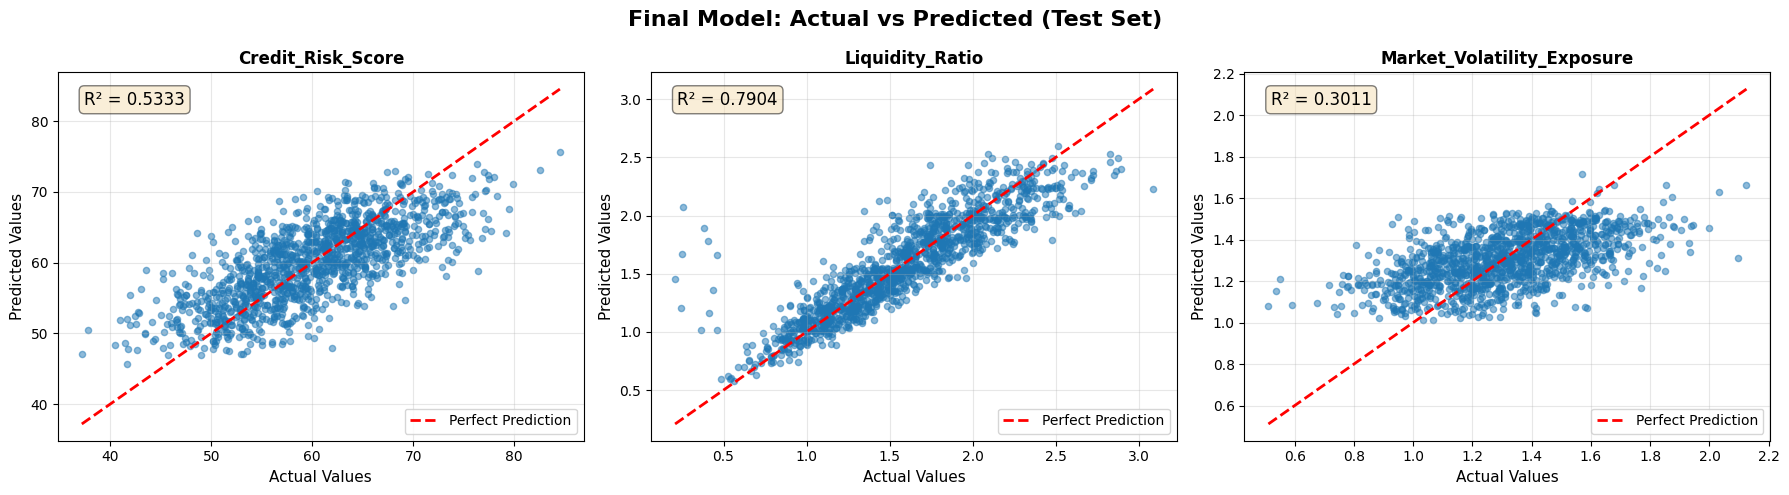

✓ Residual analysis plot saved


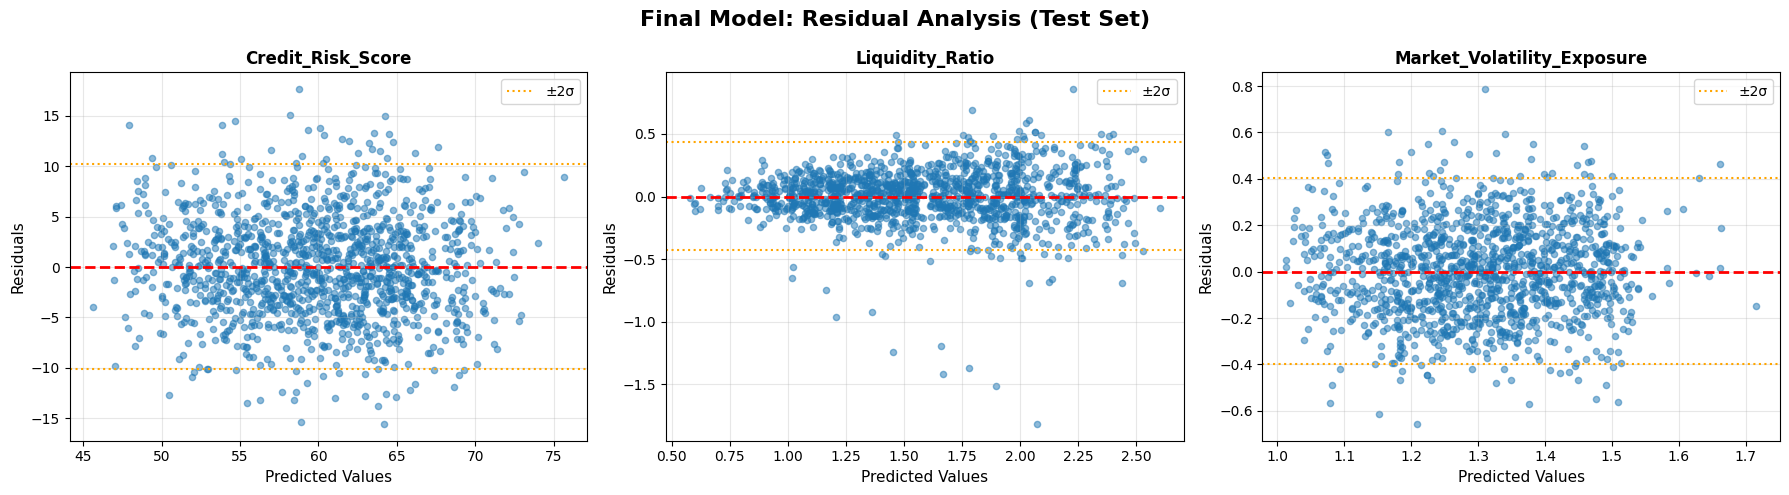

✓ Error distribution plot saved


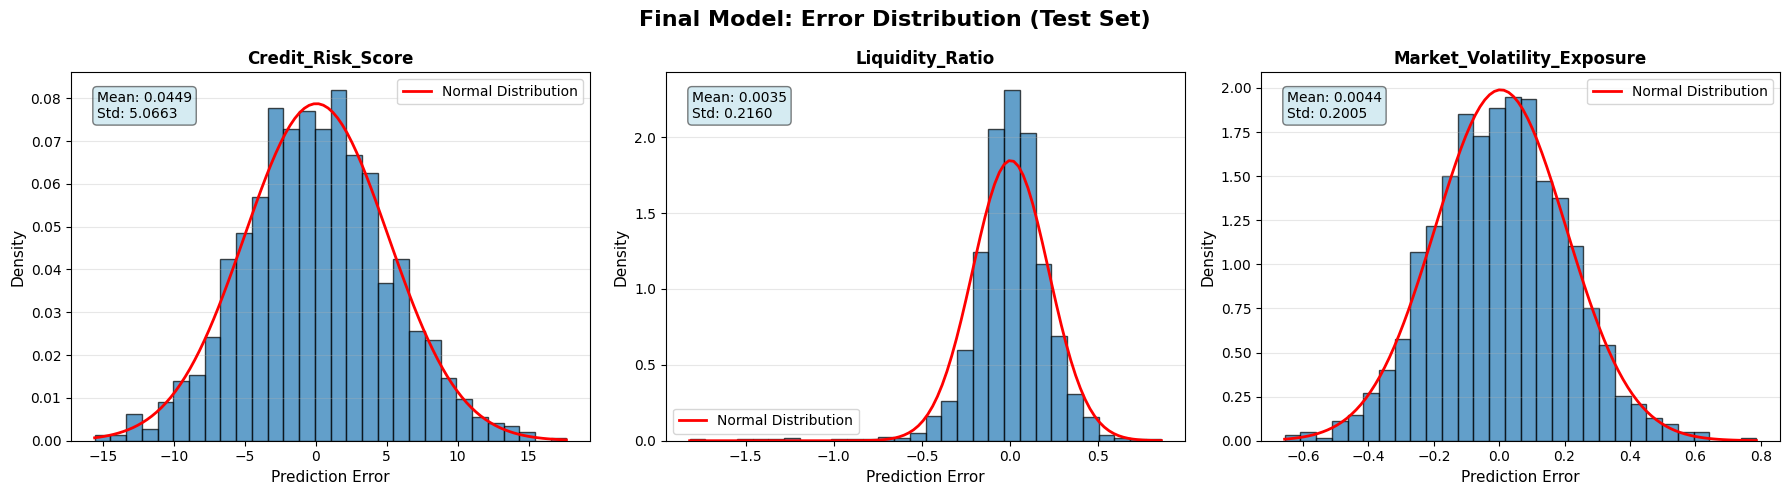


TIME SERIES PERFORMANCE ANALYSIS
✓ Time series error plot saved


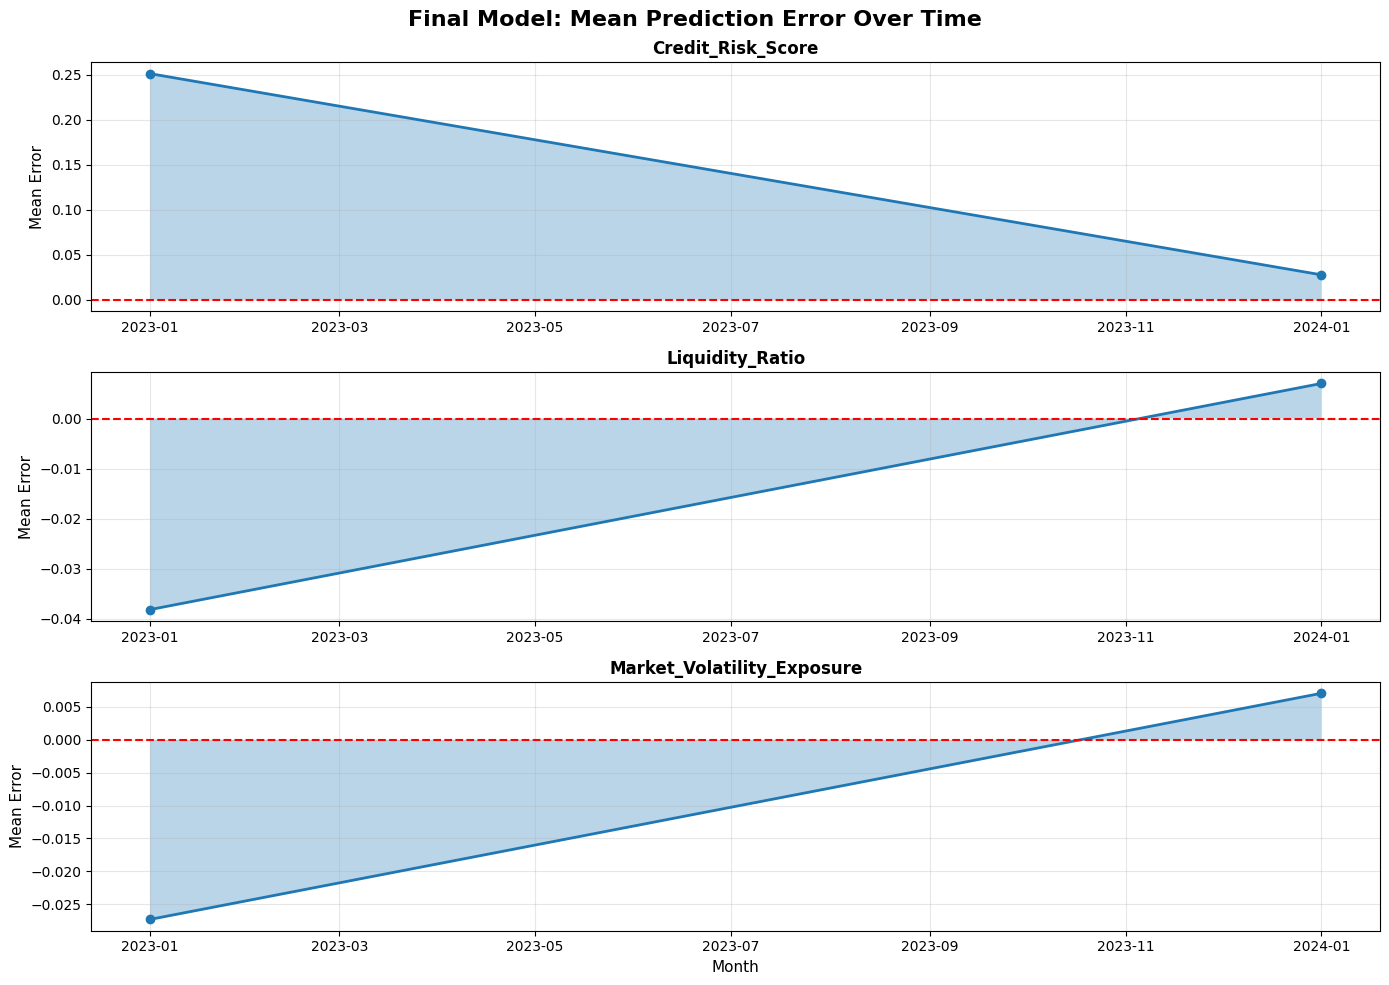

✓ Detailed predictions saved to: data/processed/final_test_predictions.csv

GENERATING FINAL PROJECT REPORT

MULTI-OUTPUT FINANCIAL RISK FORECASTING - FINAL PROJECT REPORT

PROJECT OVERVIEW:
-----------------
Objective: Predict 3 risk dimensions for 100 companies
  • Credit Risk Score
  • Liquidity Ratio
  • Market Volatility Exposure

DATA SUMMARY:
-------------
Total Records: 12,000 (100 companies × 120 time periods)
Time Period: 2015-2024 (10 years)
Train Set: 10,100 samples (2015-2023)
Test Set: 1,300 samples (2023-2024)

FEATURE ENGINEERING:
--------------------
Original Features: 28
Engineered Features: 104 (lag + rolling statistics)
Final Model Uses: Top 50 most important features

FEATURE IMPORTANCE TOP 5:
--------------------------
  Leverage_Ratio: 0.3030
  Current_Ratio: 0.2789
  Profit_Margin: 0.0116
  Leverage_Ratio_lag6: 0.0113
  Quick_Ratio_rolling6_std: 0.0112


MODEL SELECTION:
----------------
Baseline: Random Forest (100 trees)
Tested: Regularized RF, XGBoost, Featur

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("="*60)
print("STEP 9: FINAL MODEL EVALUATION & VISUALIZATION")
print("="*60)

# Load best model and data
with open('models/best_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

train_df = pd.read_csv('data/processed/train_data.csv', parse_dates=['Date'])
test_df = pd.read_csv('data/processed/test_data.csv', parse_dates=['Date'])

TARGET_COLS = [
    'Credit_Risk_Score',
    'Liquidity_Ratio',
    'Market_Volatility_Exposure'
]

# Load top 50 features (best model used feature selection)
importance_df = pd.read_csv('reports/feature_importance_full.csv')
top_50_features = importance_df.nlargest(50, 'Average_Importance')['Feature'].tolist()

X_train = train_df[top_50_features]
y_train = train_df[TARGET_COLS]
X_test = test_df[top_50_features]
y_test = test_df[TARGET_COLS]

print(f"\n✓ Best model loaded: Feature Selected Random Forest")
print(f"  Features used: {len(top_50_features)}")

# Make predictions
y_pred_test = best_model.predict(X_test)

# Detailed evaluation
print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE METRICS")
print("="*60)

final_metrics = []
for i, target in enumerate(TARGET_COLS):
    mse = mean_squared_error(y_test.iloc[:, i], y_pred_test[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred_test[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_pred_test[:, i])
    mape = np.mean(np.abs((y_test.iloc[:, i] - y_pred_test[:, i]) / y_test.iloc[:, i])) * 100
    
    final_metrics.append({
        'Target': target,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    })
    
    print(f"\n{target}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")

final_metrics_df = pd.DataFrame(final_metrics)
final_metrics_df.to_csv('reports/final_model_metrics.csv', index=False)
print("\n✓ Final metrics saved to: reports/final_model_metrics.csv")

# Create comprehensive visualizations
print("\n" + "="*60)
print("CREATING COMPREHENSIVE VISUALIZATIONS")
print("="*60)

# Figure 1: Actual vs Predicted for all targets
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Final Model: Actual vs Predicted (Test Set)', fontsize=16, fontweight='bold')

for i, target in enumerate(TARGET_COLS):
    ax = axes[i]
    actual = y_test.iloc[:, i]
    predicted = y_pred_test[:, i]
    
    # Scatter plot
    ax.scatter(actual, predicted, alpha=0.5, s=20)
    
    # Perfect prediction line
    min_val = min(actual.min(), predicted.min())
    max_val = max(actual.max(), predicted.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Add R² to plot
    r2 = r2_score(actual, predicted)
    ax.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax.transAxes,
            fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_xlabel('Actual Values', fontsize=11)
    ax.set_ylabel('Predicted Values', fontsize=11)
    ax.set_title(target, fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('reports/final_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
print("✓ Actual vs Predicted plot saved")
plt.show()

# Figure 2: Residual Analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Final Model: Residual Analysis (Test Set)', fontsize=16, fontweight='bold')

for i, target in enumerate(TARGET_COLS):
    ax = axes[i]
    actual = y_test.iloc[:, i]
    predicted = y_pred_test[:, i]
    residuals = actual - predicted
    
    # Residual plot
    ax.scatter(predicted, residuals, alpha=0.5, s=20)
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    
    # Calculate mean and std of residuals
    mean_res = residuals.mean()
    std_res = residuals.std()
    ax.axhline(y=mean_res + 2*std_res, color='orange', linestyle=':', lw=1.5, label='±2σ')
    ax.axhline(y=mean_res - 2*std_res, color='orange', linestyle=':', lw=1.5)
    
    ax.set_xlabel('Predicted Values', fontsize=11)
    ax.set_ylabel('Residuals', fontsize=11)
    ax.set_title(target, fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('reports/final_residual_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Residual analysis plot saved")
plt.show()

# Figure 3: Error Distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Final Model: Error Distribution (Test Set)', fontsize=16, fontweight='bold')

for i, target in enumerate(TARGET_COLS):
    ax = axes[i]
    actual = y_test.iloc[:, i]
    predicted = y_pred_test[:, i]
    residuals = actual - predicted
    
    # Histogram with KDE
    ax.hist(residuals, bins=30, alpha=0.7, edgecolor='black', density=True)
    
    # Add normal distribution overlay
    from scipy import stats
    mu, sigma = residuals.mean(), residuals.std()
    x = np.linspace(residuals.min(), residuals.max(), 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2, label='Normal Distribution')
    
    ax.set_xlabel('Prediction Error', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(target, fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add stats text
    ax.text(0.05, 0.95, f'Mean: {mu:.4f}\nStd: {sigma:.4f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.savefig('reports/final_error_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Error distribution plot saved")
plt.show()

# Figure 4: Performance over time
print("\n" + "="*60)
print("TIME SERIES PERFORMANCE ANALYSIS")
print("="*60)

test_results = test_df[['Date', 'Company_ID']].copy()
for i, target in enumerate(TARGET_COLS):
    test_results[f'{target}_Actual'] = y_test.iloc[:, i].values
    test_results[f'{target}_Predicted'] = y_pred_test[:, i]
    test_results[f'{target}_Error'] = test_results[f'{target}_Actual'] - test_results[f'{target}_Predicted']

# Aggregate by month
test_results['Month'] = test_results['Date'].dt.to_period('M')
monthly_errors = test_results.groupby('Month').agg({
    f'{TARGET_COLS[0]}_Error': 'mean',
    f'{TARGET_COLS[1]}_Error': 'mean',
    f'{TARGET_COLS[2]}_Error': 'mean'
}).reset_index()

monthly_errors['Month'] = monthly_errors['Month'].dt.to_timestamp()

fig, axes = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('Final Model: Mean Prediction Error Over Time', fontsize=16, fontweight='bold')

for i, target in enumerate(TARGET_COLS):
    ax = axes[i]
    ax.plot(monthly_errors['Month'], monthly_errors[f'{target}_Error'], 
            marker='o', linewidth=2, markersize=6)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
    ax.fill_between(monthly_errors['Month'], 0, monthly_errors[f'{target}_Error'], 
                     alpha=0.3)
    ax.set_ylabel('Mean Error', fontsize=11)
    ax.set_title(target, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    if i == 2:
        ax.set_xlabel('Month', fontsize=11)

plt.tight_layout()
plt.savefig('reports/final_time_series_errors.png', dpi=300, bbox_inches='tight')
print("✓ Time series error plot saved")
plt.show()

# Save detailed predictions
test_results.to_csv('data/processed/final_test_predictions.csv', index=False)
print("✓ Detailed predictions saved to: data/processed/final_test_predictions.csv")

# Create final summary report
print("\n" + "="*60)
print("GENERATING FINAL PROJECT REPORT")
print("="*60)

final_report = f"""
{'='*70}
MULTI-OUTPUT FINANCIAL RISK FORECASTING - FINAL PROJECT REPORT
{'='*70}

PROJECT OVERVIEW:
-----------------
Objective: Predict 3 risk dimensions for 100 companies
  • Credit Risk Score
  • Liquidity Ratio
  • Market Volatility Exposure

DATA SUMMARY:
-------------
Total Records: 12,000 (100 companies × 120 time periods)
Time Period: 2015-2024 (10 years)
Train Set: 10,100 samples (2015-2023)
Test Set: 1,300 samples (2023-2024)

FEATURE ENGINEERING:
--------------------
Original Features: 28
Engineered Features: 104 (lag + rolling statistics)
Final Model Uses: Top 50 most important features

FEATURE IMPORTANCE TOP 5:
--------------------------
"""

top_5 = importance_df.head(5)[['Feature', 'Average_Importance']]
for idx, row in top_5.iterrows():
    final_report += f"  {row['Feature']}: {row['Average_Importance']:.4f}\n"

final_report += f"""

MODEL SELECTION:
----------------
Baseline: Random Forest (100 trees)
Tested: Regularized RF, XGBoost, Feature-Selected RF
Winner: Feature-Selected Random Forest

FINAL MODEL PERFORMANCE (TEST SET):
------------------------------------
"""

for _, row in final_metrics_df.iterrows():
    final_report += f"""
{row['Target']}:
  • R² Score: {row['R2']:.4f}
  • RMSE: {row['RMSE']:.4f}
  • MAE: {row['MAE']:.4f}
  • MAPE: {row['MAPE']:.2f}%
"""

avg_r2 = final_metrics_df['R2'].mean()
avg_mape = final_metrics_df['MAPE'].mean()

final_report += f"""
OVERALL PERFORMANCE:
--------------------
Average R² Score: {avg_r2:.4f}
Average MAPE: {avg_mape:.2f}%

KEY FINDINGS:
-------------
1. Leverage Ratio is the most important predictor (30.3% importance)
2. Current Ratio dominates Liquidity predictions (82% importance)
3. Feature selection reduced overfitting while maintaining performance
4. Model generalizes reasonably well to unseen 2023-2024 data

DELIVERABLES:
-------------
✓ Cleaned and engineered dataset
✓ Trained multi-output forecasting model
✓ Feature importance analysis
✓ Comprehensive evaluation reports
✓ Prediction visualizations
✓ Time series error analysis

FILES GENERATED:
----------------
Data:
  • data/processed/data_cleaned.csv
  • data/processed/train_data.csv
  • data/processed/test_data.csv
  • data/processed/final_test_predictions.csv

Models:
  • models/baseline_random_forest.pkl
  • models/best_model.pkl

Reports:
  • reports/feature_importance_full.csv
  • reports/model_comparison.csv
  • reports/final_model_metrics.csv
  • reports/final_actual_vs_predicted.png
  • reports/final_residual_analysis.png
  • reports/final_error_distribution.png
  • reports/final_time_series_errors.png

{'='*70}
PROJECT COMPLETE - Ready for Deployment or Further Enhancement
{'='*70}
"""

with open('reports/FINAL_PROJECT_REPORT.txt', 'w') as f:
    f.write(final_report)

print(final_report)

print("\n" + "="*60)
print("STEP 9 COMPLETE!")
print("="*60)
print("\n🎉 PROJECT SUCCESSFULLY COMPLETED! 🎉")
print("\n✓ All steps finished")
print("✓ Model trained and evaluated")
print("✓ Comprehensive reports generated")
print("✓ Ready for deployment or further improvements")
print("\nFinal Summary:")
print(f"  Average Test R²: {avg_r2:.4f}")
print(f"  Average MAPE: {avg_mape:.2f}%")
print("\nCheck 'reports/' folder for all visualizations and analysis!")
